## emcee implementation of MCMC wrapper around DUSTY

under construction

In [51]:
%matplotlib inline
import numpy as np
from astropy.io import ascii
from os import system
import emcee
import matplotlib.pyplot as plt
import corner
import time
import sys

In [3]:
def rl(rv,x):
    "rv is typically 3.1, x is 1/lambda [microns^-1]"
    if x < 1.1:
        a =  0.574*x**1.61
        b = -0.527*x**1.61
    else:
        if x < 3.3:
            y = x-1.82
            a = (1.0+0.17699*y-0.50447*y*y-0.02427*y**3+0.72085*y**4 + 0.01979*y**5-0.77530*y**6+0.32999*y**7)
            b = (1.41338*y+2.28305*y**2+1.07233*y**3-5.38434*y**4-0.62251*y**5+5.30260*y**6-2.09002*y**7)
        else:
            if x < 5.9:
                fa = 0.0
                fb = 0.0
            else:
                fa = -0.04473*(x-5.9)**2 - 0.009779*(x-5.9)**3
                fb =  0.21300*(x-5.9)**2 + 0.120700*(x-5.9)**3
            a =  1.752 - 0.316*x - 0.104/((x-4.67)**2+0.341) + fa
            b = -3.090 + 1.825*x + 1.206/((x-4.67)**2+0.263) + fb
    rlval = rv*(a+b/rv)
    return rlval

In [4]:
def locate(xx,n,x):
  jl = 0
  ju = n+1
  while ju - jl > 1:
    jm = (ju+jl) / 2
    if (xx[n-1] > xx[0] and x > xx[jm-1] ) or (xx[n-1] < xx[0] and x < xx[jm-1]):
      jl = jm
    else:
      ju = jm
  j = jl
  return j

def geninput(tstar,tau,td,thick,ebv,idtype,fileuse):
  output = open('foo1.inp','w')
  if (tstar < 3500 or tstar > 48999) or (blackbody):
    output.write('Spectrum = 1\n')
    output.write('Number of BB = 1\n')
    output.write('Temperature = %0.2f\n' % (tstar))
  else:
    output.write('Spectrum = 5   \n')
    output.write('%s\n' % (fileuse))
  output.write('   optical properties index = 1 \n')
  output.write('   #   Sil-Ow  Sil-Oc  Sil-DL  grf-DL  amC-Hn  SiC-Pg \n')
  if idtype == 0:
    output.write('    x = 0.00    0.00   0.00    1.00    0.00    0.00 \n')
  else:
    output.write('    x = 0.00    0.00   1.00    0.00    0.00    0.00 \n')
  if custom_grain_distribution:
    output.write('- size distribution = 2  % custom       \n')
    output.write('  q = 3.5, a(min) = %s micron, a(max) = %s micron\n' % (aminnew,amaxnew))
  else:
    output.write('- size distribution = 1  % standard MRN    \n')
  output.write('- temperature = %s K \n' % (td))
  output.write('- density type = 1                   \n')
  output.write('- number of powers = 1              \n')
  output.write('- shells relative thickness = %s\n' % (thick))
  output.write('- power = 2 \n')
  output.write('- grid type = 1                  % linear grid \n')
  output.write('- lambda0 = 0.55 micron          % optical depth specified  \n')
  output.write('- tau(min) = '+str(tau)+' ; tau(max) = 1000.0   % for the visual wavelength \n')
  output.write('- number of models = 1           \n')
  output.write('- accuracy for flux conservation = 0.05             \n')
  output.write('- verbosity flag;                              verbose = 1  \n')
  output.write('- properties of emerging spectra;            fname.spp = 1  \n')
  output.write('- detailed spectra for each model;          fname.s### = 1  \n')
  output.write('- images at specified wavelengths;          fname.i### = 1  \n')
  output.write('     number of wavelengths = 5  \n')
  output.write('     wavelengths = 3.5, 4.5, 6.0, 8.0, 24.0 micron  \n')
  output.write('- radial profiles for each model;           fname.r### = 1  \n')
  output.write('- detailed run-time messages;               fname.m### = 1  \n')
  output.write('- visibility function at spec. wavelengths; fname.v### = 0  \n')
  output.close()

  if verbose: print 'calling dusty with tstar = %0.1f; tau = %0.2f; td = %0.1f; thick = %0.2f; amin = %0.3f amax = %0.3f; E(B-V) = %0.4f; R_V = %0.2f' % (tstar,tau,td,thick,aminnew,amaxnew,ebv,rvnew)
  system('./dusty')

  ierror = 0
  #try:
  data = ascii.read('foo1.stb')
  lam = data['col1']
  flx = data['col2']
  npt = len(lam)

  i = 0
  with open('foo1.out','r') as f:
    for line in f:
      if i == 42:
        # print 'line read in from foo1.out:', line
        line_s = line.split()
        id = int(line_s[0])
        tau0 = float(line_s[1])
        f1 = float(line_s[2])
        r1 = float(line_s[3])
        r1torstar = float(line_s[4])
        theta1 = float(line_s[5])
        tdout = float(line_s[6])
        break
      i += 1
  #except:
  #  ierror = 1
  #  lam = np.nan
  #  flx = np.nan
  #  npt = np.nan
  #  r1 = np.nan
  return lam, flx, npt, r1, ierror

In [30]:
# let's start with the simplest scenario of fitting a blackbody temperature 
#   to a set of photometric constraints
def lnprior(theta):
    #tstarnew, taunew, tdnew, thicknew, ebvnew = theta
    for i,parameter in enumerate(parameters2vary):
        if not param[parameter+'min'] < theta[i] < param[parameter+'max']:
            return -np.inf
    return 0

def lnlike(theta, mlumobs, merrobs):
    for i,parameter in enumerate(parameters2vary):
        param[parameter] = theta[i]
    tstarnew = 10**param['tstar']
    ebvnew = 10**param['ebv']
    if np.isinf(ebvnew): ebvnew = 0
    taunew = 10**param['tau']-1.
    if np.isinf(taunew): taunew = 0
    tdnew = 10**param['td']
    thicknew = 10**param['thick']
    #tstarnew, taunew, tdnew, thicknew, ebvnew = theta
    lam, flx, npt, r1, ierror = geninput(tstarnew,taunew,tdnew,thicknew,ebvnew,idtype,fileuse)
    if ierror == 1:
        #if verbose: print 'had error, trying new model'
        #continue
        print 'IO error with geninput'
    # convert magnitudes to take out effect of extinction
    # mlum mlam lebvnew
    # ecor = 10.0**(-0.4*rval*ebvnew)
    mlum = np.zeros(len(mlumobs))
    merr = np.zeros(len(mlumobs))
    if veryverbose: print 'Extinction-corrected luminosities:'
    for i in xrange(len(mlam)):
        rlval = rl(rv,1.0/mlam[i])
        ecor = 10.0**(-0.4*rlval*ebvnew)
        mlum[i] = mlumobs[i] / ecor
        merr[i] = merrobs[i] / ecor
    if veryverbose: print '    %s %s %s %s (%s)' % (mlam[i], mlum[i], merr[i], filters[i], ecor)
    gtzero = (mlum > 0)
    ltzero = np.invert(gtzero)
    mluml = np.zeros(len(mlumobs))
    merrl = np.zeros(len(mlumobs))
    mluml[gtzero] = np.log10(mlum[gtzero])
    merrl[gtzero] = merr[gtzero]/mlum[gtzero]/np.log(10)
    merrl[ltzero] = np.log10(merr[ltzero])
    # loop through filters with luminosity constraints
    aa = 0.0
    bb = 0.0
    val = np.zeros(100)
    vall = np.zeros(100)
    for i in xrange(nm):
        j = locate(lam,npt,mlam[i]) - 1     # -1 because indexed to 0
        val[i] = flx[j] + (flx[j+1]-flx[j])*(mlam[i]-lam[j])/(lam[j+1]-lam[j])
        if debug: print 'i,j ',i,j,flx[j],flx[j+1],lam[j],lam[j+1],mlam[i],val[i]
        #print 'val[%s] = %s' % (i,val[i])
        # This is the luminosity chi^2 minimization
        vall[i] = np.log10(val[i]+1.e-32)
        if debug: print 'vall[%s] = %s' % (i,vall[i])
        if mlum[i] > 0:
            aa = aa + (mluml[i]-vall[i])/merrl[i]**2
            bb = bb + 1.0/merrl[i]**2
    sluml = aa/bb
    # r1 output from DUSTY is the distance at which a point source w/luminosity 10^4 L_sun produces the bolometric flux F_e1
    r1 = np.log10(r1) + 0.5*(sluml-4.0)   # scale radius for luminosity
    r2 = r1 + np.log10(thicknew)
    # dusty reports a radius scaled to a luminosity of 10^4
    # so this scales it to the luminosity you just worked out
    chi = 0.0
    chis = {}
    for i in xrange(nm):
        if mlum[i] > 0:
            chis[filters[i]] = ((mluml[i]-sluml-vall[i])/merrl[i])**2
            chi = chi + chis[filters[i]]
            #chi = chi + ((mluml[i]-sluml-vall[i])/merrl[i])**2
            if debug: print '%s = chi + ((%s-%s-%s)/%s)**2' % (chi,mluml[i],sluml,vall[i],merrl[i])
        if mlum[i] < 0:
            rat = 10.0**(sluml+vall[i]-merrl[i])
            if debug: print 'rat = %s = 10**(%s+%s-%s)' % (rat,sluml,vall[i],merrl[i])
            chis[filters[i]] = rat*rat
            chi = chi + chis[filters[i]]
            #chi = chi + rat*rat
    if debug: print 'tstar = %d -> chi2 = %0.1f' % (tstarnew, chi)
    return -0.5*chi

def lnprob(theta, mlumobs, merrobs):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, mlumobs, merrobs)

In [44]:
verbose = False
veryverbose = False
blackbody = True
photometry_file = '/scr/sma/m31/dusty/20150306_blackbody/mags20150306.dat'

In [45]:
# read in the photometry file (magnitudes, filters)
data = ascii.read(photometry_file)
mlam = data['col1']
mlumobs = data['col2']
#mlumlobs = np.zeros(len(mlumobs))
#merrlobs = np.zeros(len(mlumobs))
#gtzero = (mlumobs > 0)
#ltzero = np.invert(gtzero)
#mlumlobs[gtzero] = np.log10(mlumobs[gtzero])
merrobs = data['col3']
#merrlobs[gtzero] = merrobs[gtzero]/mlumobs[gtzero]/np.log(10)
#merrlobs[ltzero] = np.log10(merrobs[ltzero])
filters = data['col4']
#templam, trans = read_filters(filters)
nm = np.shape(mlumobs)[0]
if verbose: print 'read %d data points' % (nm)

In [46]:
def scaled2unscaled(pos):
    unscaled = []
    for i,parameter in enumerate(parameters2vary):
        if parameter == 'tstar':
            unscaled.append(10**pos)
        elif parameter == 'td':
            unscaled.append()
    unscaled['tstar'] = 10**param['tstar']
    unscaled['td'] = 10**param['td']
    unscaled['tau'] = 10**(param['tau']-1.)
    unscaled['ebv'] = 10**param['ebv']
    unscaled['thick'] = 10**param['thick']
    return unscaled

In [47]:
parameters2vary = ['tstar','tau','td']
tstar = 4000.
td = 250.
tau = 0.1
ebv = 0.2
thick = 2.
tstarmin = 500.
tstarmax = 40000.
tdmin = 40.
tdmax = 2000.
taumin = 0
taumax = 10.
ebvmax = 2.0
ebvmin = 0.001
thickmin = 1.1
thickmax = 100.

idtype = 1
fileuse = ''
custom_grain_distribution = False
debug = False
aminnew = 0.005
amaxnew = 0.25
rvnew = 3.1
rv = 3.1

param = {}
param['tstarmin'] = np.log10(tstarmin)
param['tstar'] = np.log10(tstar)
param['tstarmax'] = np.log10(tstarmax)
param['tdmin'] = np.log10(tdmin)
param['td'] = np.log10(td)
param['tdmax'] = np.log10(tdmax)
param['taumin'] = np.log10(taumin+1.)
param['tau'] = np.log10(tau+1.)
param['taumax'] = np.log10(taumax+1.)
param['ebvmin'] = np.log10(ebvmin)
param['ebv'] = np.log10(ebv)
param['ebvmax'] = np.log10(ebvmax)
param['thickmin'] = np.log10(thickmin)
param['thick'] = np.log10(thick)
param['thickmax'] = np.log10(thickmax)

ndim = len(parameters2vary)
theta = []
for parameter in parameters2vary:
    theta.append(param[parameter]) 

lnlike(theta, mlumobs, merrobs)

-37.199927261880489

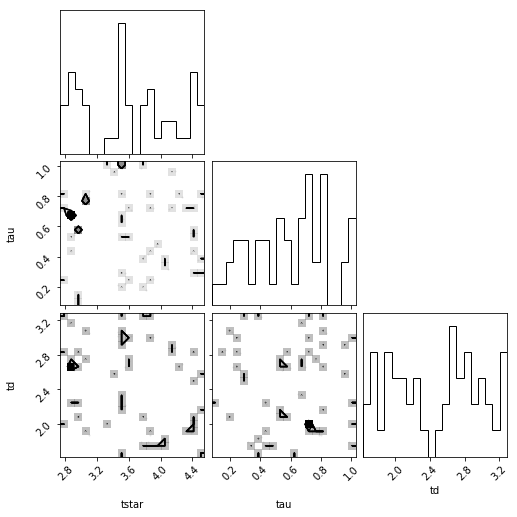

In [68]:
nwalkers = 50

# Initialize the chain
# Choice 1: chain uniformly distributed in the range of the parameters

pos_min = []
pos_max = []
for i,parameter in enumerate(parameters2vary):
    #pos_min.append(0.9*param[parameter])
    #pos_max.append(1.1*param[parameter])
    pos_min.append(param[parameter+'min'])
    pos_max.append(param[parameter+'max'])

pos_min = np.array(pos_min)
pos_max = np.array(pos_max)
psize = pos_max - pos_min
pos = [pos_min + psize*np.random.rand(ndim) for i in range(nwalkers)]

# Visualize the initialization

fig = corner.corner(pos, labels=parameters2vary)
#fig = corner.corner(pos, labels=["$T_{*}$","$E(B-V)$"], extents=[[3600, 10000], [0, 0.5]], 
#                      truths=[4000, 0.2])
#fig.set_size_inches(10,10)

In [69]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(mlumobs, merrobs))

In [70]:
#time0 = time.time()
# burnin phase
#pos, prob, state  = sampler.run_mcmc(pos, 10)
#sampler.reset()
#time1=time.time()
#print time1-time0
#time0 = time.time()
# perform MCMC
nsteps = 250
width = 30
time0=time.time()
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    n = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
sys.stdout.write("\n")
#pos, prob, state  = sampler.run_mcmc(pos, 5)
time1=time.time()
print time1-time0
samples = sampler.flatchain
samples.shape

[##############################]
20896.814678


(12500, 3)

array([ 0.4 ,  0.44,  0.48,  0.  ,  0.56,  0.44,  0.44,  0.48,  0.6 ,
        0.48,  0.  ,  0.4 ,  0.52,  0.6 ,  0.4 ,  0.36,  0.24,  0.44,
        0.16,  0.24])

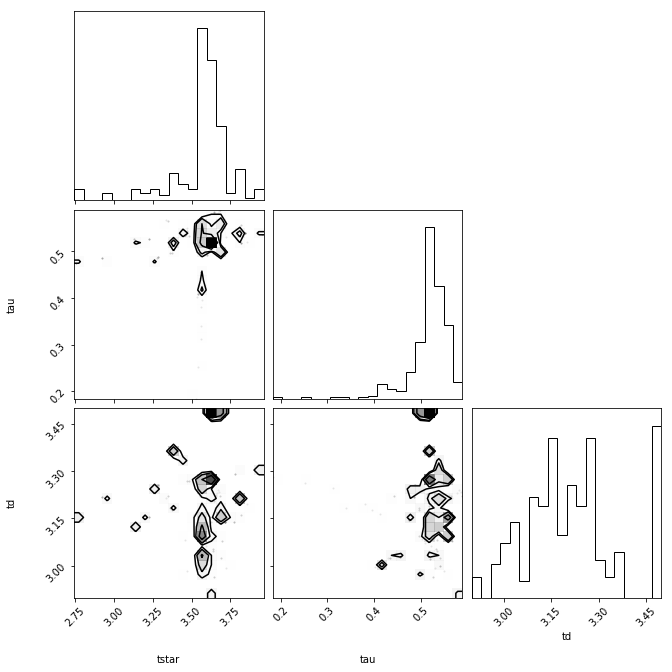

In [65]:
#let's plot the results
fig = corner.corner(samples[200:], labels=parameters2vary)
fig.set_size_inches(10,10)
sampler.acceptance_fraction

(20, 25, 3)


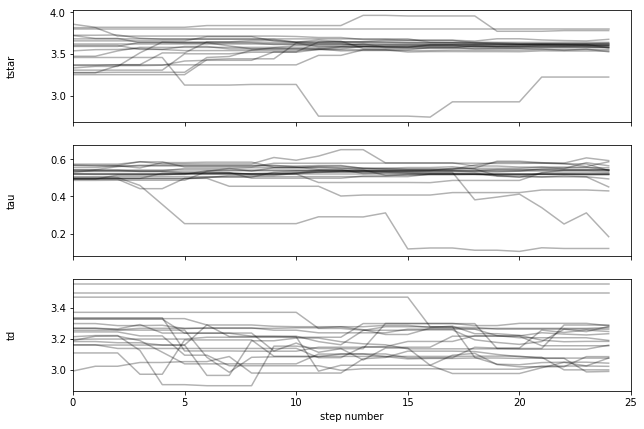

In [67]:
fig, axes = plt.subplots(ndim, figsize=(10,7), sharex=True)
samples = sampler.chain
labels = parameters2vary
swapsamples = np.swapaxes(samples, 0,1)
print np.shape(samples)
for i in range(ndim):
    ax = axes[i]
    ax.plot(swapsamples[:,:,i], 'k', alpha=0.3)
    ax.set_xlim(0,nsteps)
    #ax.set_xlim(0, np.shape(samples)[1])
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel('step number')